<a href="https://colab.research.google.com/github/DABallentine/knowledge_discovery_charlotte/blob/Imad/EDA_and_Preprocessing_with_MAPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Charlotte 311 Service Request Analysis

<h1> <b> Exploratory Data Analysis with Geopandas </b> </h1>

## Data Import and Survey

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Function to read data from URL
def read_data_from_URL(url):
    df=pd.read_csv(url)
    return df

In [3]:
# Read in the data
serv_req_url='https://bitbucket.org/nthammad-uncc/test_repo/raw/7508681846896228bb87fd1989ec50ca2d592bc5/data/Service_Requests_311.csv'
requests = read_data_from_URL(serv_req_url)

## Initial Variable Selection


<b> The following variables will be dropped: </b>
<ol>
<li> X - redundant with X_COORD </li>
<li> Y - redundant with Y_COORD </li>
<li> FISCAL YEAR - redundant with RECEIVED_DATE </li>
<li> FISCAL MONTH - redundant with RECEIVED_DATE </li>
<li> TITLE - redundant with REQUEST_TYPE </li>
<li> CMPD_DIVISION - too many missing values </li>
<li> STREET_DIRECTION - redundant </li>
<li> STREET_NAME - redundant </li>
<li> STREET_TYPE - redundant </li>
<li> CITY - redundant </li>
<li> STATE - redundant </li>
<li> COUNCIL_DISTRICT - too many missing values </li>
<li> GLOBAL_ID - no predictive value </li>
<li> PID - no predictive value </li>
<li> SHAPE - all missing </li>
</ol>

In [4]:
requests.drop(requests.iloc[:, [0,1,4,6,7,11,12,15,16,17,18,19,26,27,28,29]], axis=1, inplace=True)
requests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631510 entries, 0 to 1631509
Data columns (total 14 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   OBJECTID                    1631510 non-null  int64  
 1   DEPARTMENT                  1631510 non-null  object 
 2   REQUEST_NO                  1631510 non-null  int64  
 3   REQUEST_TYPE                1631510 non-null  object 
 4   RECEIVED_DATE               1631510 non-null  object 
 5   INTERNAL_FIELD_OBSERVATION  1631510 non-null  object 
 6   NEIGHBORHOOD_PROFILE_AREA   1559062 non-null  float64
 7   BLOCK_NO                    1587157 non-null  float64
 8   ZIP_CODE                    1586427 non-null  float64
 9   FULL_ADDRESS                1624342 non-null  object 
 10  X_COORD                     1559084 non-null  float64
 11  Y_COORD                     1559084 non-null  float64
 12  LATITUDE                    1559077 non-null  float64
 1

In [5]:
# Drop all records which are missing addresses or LATITUDE and LONGITUDE
print('Size before dropping records:', requests.shape)
start_size = requests.shape[0]
requests = requests[~requests['FULL_ADDRESS'].isnull() & 
                    ~requests['ZIP_CODE'].isnull() &
                    ~requests['LATITUDE'].isnull() & 
                    ~requests['LONGITUDE'].isnull()]
num_nulls = start_size - requests.shape[0]
print('Size after dropping {dropped} records:'.format(dropped = num_nulls), requests.shape)

Size before dropping records: (1631510, 14)
Size after dropping 99170 records: (1532340, 14)


In [6]:
# Divide categories by season of the year
requests['RECEIVED_DATE'] = pd.to_datetime(requests['RECEIVED_DATE'], format='%Y/%m/%d %H:%M')
requests['SEASON'] = requests['RECEIVED_DATE'].dt.quarter

# Create new columns in the requests dataset for month and year
requests['RECEIVED_MONTH']= pd.to_datetime(requests['RECEIVED_DATE']).dt.month
requests['RECEIVED_YEAR']= pd.to_datetime(requests['RECEIVED_DATE']).dt.year

# Mapping GeoData

In [7]:
# to read and visualize spatial data
! pip install geopandas
import geopandas as gpd

! pip install contextily
import contextily as ctx

! pip install descartes
import descartes

In [8]:
# Covert our merged_requests_df dataframe into a Geopandas Dataframe
# We will set a Coordinate reference systems (CRS) using Longitude and Latitude in our 311 data set

geo_requests = gpd.GeoDataFrame(requests, 
                         crs = 'EPSG:4326',
                         geometry = gpd.points_from_xy(requests.LONGITUDE, 
                                                       requests.LATITUDE))



In [9]:
# reproject to web mercator
geo_requests = geo_requests.to_crs(epsg=4326)



In [10]:
# convert lat/lon to floats
geo_requests.LONGITUDE = geo_requests.LONGITUDE.astype('float')
geo_requests.LATITUDE = geo_requests.LATITUDE.astype('float')



In [11]:
# drop the unmapped rows - anything that has a longitude of 0 should be removed
geo_requests = geo_requests[geo_requests.LONGITUDE!=0]
geo_requests = geo_requests[geo_requests.LATITUDE!=0]



In [12]:
# Check for missing values
geo_requests.isna().sum()

OBJECTID                       0
DEPARTMENT                     0
REQUEST_NO                     0
REQUEST_TYPE                   0
RECEIVED_DATE                  0
INTERNAL_FIELD_OBSERVATION     0
NEIGHBORHOOD_PROFILE_AREA     15
BLOCK_NO                       0
ZIP_CODE                       0
FULL_ADDRESS                   0
X_COORD                        0
Y_COORD                        0
LATITUDE                       0
LONGITUDE                      0
SEASON                         0
RECEIVED_MONTH                 0
RECEIVED_YEAR                  0
geometry                       0
dtype: int64

In [13]:
geo_requests.head()

,OBJECTID,DEPARTMENT,REQUEST_NO,REQUEST_TYPE,RECEIVED_DATE,INTERNAL_FIELD_OBSERVATION,NEIGHBORHOOD_PROFILE_AREA,BLOCK_NO,ZIP_CODE,FULL_ADDRESS,X_COORD,Y_COORD,LATITUDE,LONGITUDE,SEASON,RECEIVED_MONTH,RECEIVED_YEAR,geometry
0,1,Solid Waste Services,6402056,NON_RECYCLABLE ITEMS,2016-11-07 14:25:00+00:00,N,215.0,3601.0,28226.0,"3601 KNAPDALE LN, CHARLOTTE, NC 28226",1458251.0,508075.0,35.132444,-80.812089,4,11,2016,POINT (-80.81209 35.13244)
1,2,Housing and NBHD Serv,6402064,UTILITY VERIFICATION LTR,2016-11-07 14:28:00+00:00,N,265.0,4124.0,28269.0,"4124 SILVERMERE WY, CHARLOTTE, NC 28269",1468687.0,587226.0,35.350408,-80.781941,4,11,2016,POINT (-80.78194 35.35041)
2,3,Solid Waste Services,6402082,NON_RECYCLABLE ITEMS,2016-11-07 14:34:00+00:00,N,103.0,523.0,28213.0,"523 GRAHAM MEADOW DR, CHARLOTTE, NC 28213",1471481.0,562513.0,35.282654,-80.771094,4,11,2016,POINT (-80.77109 35.28265)
3,4,Solid Waste Services,6402103,MISSED RECYCLING,2016-11-07 14:41:00+00:00,N,158.0,1801.0,28216.0,"1801 CRANDON DR, CHARLOTTE, NC 28216",1438992.0,568604.0,35.297745,-80.880327,4,11,2016,POINT (-80.88033 35.29775)
5,6,Finance/City,6402112,CWP REQUEST,2016-11-07 14:45:00+00:00,N,88.0,309.0,28208.0,"309 JONES ST APT 1, CHARLOTTE, NC 28208",1439454.0,552715.0,35.254120,-80.877772,4,11,2016,POINT (-80.87777 35.25412)


In [14]:
# Double check is Na's have been removed NOT DOING THIS BECAUSE WE MIGHT LOSE TOO MUCH DATA
# merged_requests_df.isna().sum()

In [15]:
# get the bounding box coordinates for the 311 calls data
# minx, miny, maxx, maxy = geo_requests.geometry.total_bounds
# print(minx)
# print(maxx)
# print(miny)
# print(maxy)





In [16]:

# mount and connect my drive to access shape files 

from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [17]:
# IMPORT SHAPE FILE FOR MAPPING
charlotte_zipcode_map = gpd.read_file('/content/gdrive/MyDrive/Charlotte 311 Calls Project/Data/zipcode/Zipcode.shp')


In [18]:
# Layers into a web mercator projection
# reproject to web mercator
charlotte_zipcode_map = charlotte_zipcode_map.to_crs(epsg=4326)

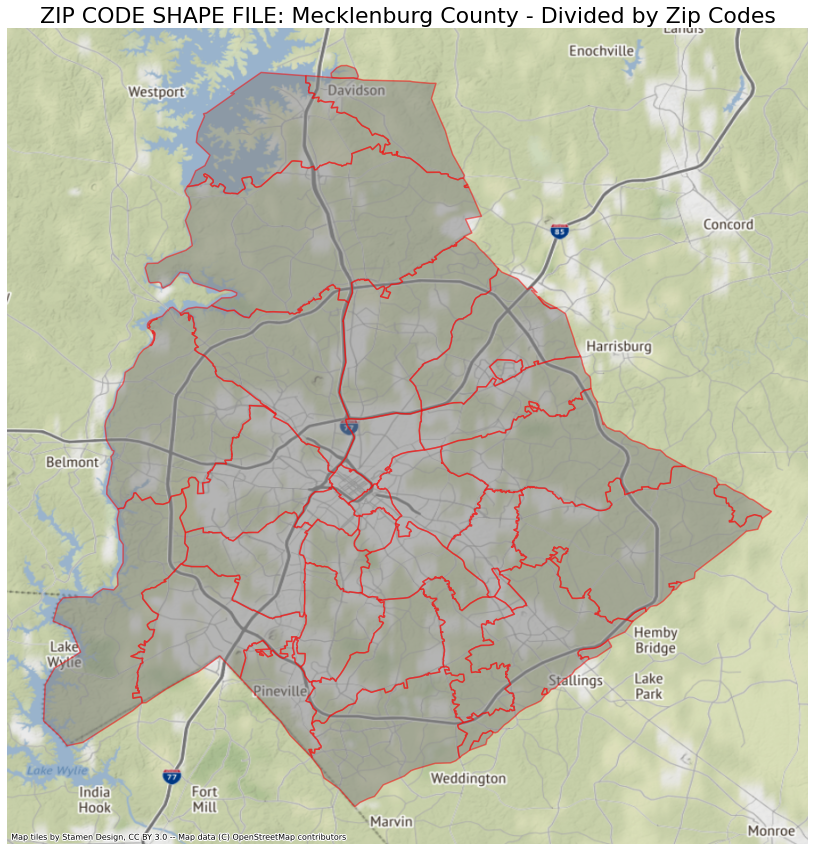

In [19]:
# Checking out what a plot looks like
fig, ax = plt.subplots(figsize=(15,15))

charlotte_zipcode_map.plot(ax=ax,
                            color='grey', 
                            edgecolor='red',
                            lw=1.5,
                            alpha=0.5)

# no axis
ax.axis('off')
ax.set_title('ZIP CODE SHAPE FILE: Mecklenburg County - Divided by Zip Codes',fontsize=22)

# add a basemap
ctx.add_basemap(ax, crs = charlotte_zipcode_map.crs.to_string())

In [20]:
geo_requests.head()

,OBJECTID,DEPARTMENT,REQUEST_NO,REQUEST_TYPE,RECEIVED_DATE,INTERNAL_FIELD_OBSERVATION,NEIGHBORHOOD_PROFILE_AREA,BLOCK_NO,ZIP_CODE,FULL_ADDRESS,X_COORD,Y_COORD,LATITUDE,LONGITUDE,SEASON,RECEIVED_MONTH,RECEIVED_YEAR,geometry
0,1,Solid Waste Services,6402056,NON_RECYCLABLE ITEMS,2016-11-07 14:25:00+00:00,N,215.0,3601.0,28226.0,"3601 KNAPDALE LN, CHARLOTTE, NC 28226",1458251.0,508075.0,35.132444,-80.812089,4,11,2016,POINT (-80.81209 35.13244)
1,2,Housing and NBHD Serv,6402064,UTILITY VERIFICATION LTR,2016-11-07 14:28:00+00:00,N,265.0,4124.0,28269.0,"4124 SILVERMERE WY, CHARLOTTE, NC 28269",1468687.0,587226.0,35.350408,-80.781941,4,11,2016,POINT (-80.78194 35.35041)
2,3,Solid Waste Services,6402082,NON_RECYCLABLE ITEMS,2016-11-07 14:34:00+00:00,N,103.0,523.0,28213.0,"523 GRAHAM MEADOW DR, CHARLOTTE, NC 28213",1471481.0,562513.0,35.282654,-80.771094,4,11,2016,POINT (-80.77109 35.28265)
3,4,Solid Waste Services,6402103,MISSED RECYCLING,2016-11-07 14:41:00+00:00,N,158.0,1801.0,28216.0,"1801 CRANDON DR, CHARLOTTE, NC 28216",1438992.0,568604.0,35.297745,-80.880327,4,11,2016,POINT (-80.88033 35.29775)
5,6,Finance/City,6402112,CWP REQUEST,2016-11-07 14:45:00+00:00,N,88.0,309.0,28208.0,"309 JONES ST APT 1, CHARLOTTE, NC 28208",1439454.0,552715.0,35.254120,-80.877772,4,11,2016,POINT (-80.87777 35.25412)


In [21]:
# SET UP SOMETHING TO FILTER BY FOR AN OVERLAY PLOT

# How to filter on 2 conditions
# df.loc[(df['Salary_in_1000']>=100) & (df['Age']< 60) & (df['FT_Team'].str.startswith('S')),['Name','FT_Team']]



# 311 Service Recycle requests plotted over various time scales

recy_year_2016 = geo_requests.loc[(geo_requests['RECEIVED_YEAR'] == 2016) & (geo_requests['REQUEST_TYPE'] == 'RECYCLABLE ITEMS')]

recy_year_2017 = geo_requests.loc[(geo_requests['RECEIVED_YEAR'] == 2017) & (geo_requests['REQUEST_TYPE'] == 'RECYCLABLE ITEMS')]

recy_year_2018 = geo_requests.loc[(geo_requests['RECEIVED_YEAR'] == 2018) & (geo_requests['REQUEST_TYPE'] == 'RECYCLABLE ITEMS')]

recy_year_2019 = geo_requests.loc[(geo_requests['RECEIVED_YEAR'] == 2019) & (geo_requests['REQUEST_TYPE'] == 'RECYCLABLE ITEMS')]

recy_year_2020 = geo_requests.loc[(geo_requests['RECEIVED_YEAR'] == 2020) & (geo_requests['REQUEST_TYPE'] == 'RECYCLABLE ITEMS')]

recy_year_2021 = geo_requests.loc[(geo_requests['RECEIVED_YEAR'] == 2021) & (geo_requests['REQUEST_TYPE'] == 'RECYCLABLE ITEMS')]



# 311 Service Recycle requests plotted over various time scales

non_recy_year_2016 = geo_requests.loc[(geo_requests['RECEIVED_YEAR'] == 2016) & (geo_requests['REQUEST_TYPE'] == 'NON_RECYCLABLE ITEMS')]

non_recy_year_2017 = geo_requests.loc[(geo_requests['RECEIVED_YEAR'] == 2017) & (geo_requests['REQUEST_TYPE'] == 'NON_RECYCLABLE ITEMS')]

non_recy_year_2018 = geo_requests.loc[(geo_requests['RECEIVED_YEAR'] == 2018) & (geo_requests['REQUEST_TYPE'] == 'NON_RECYCLABLE ITEMS')]

non_recy_year_2019 = geo_requests.loc[(geo_requests['RECEIVED_YEAR'] == 2019) & (geo_requests['REQUEST_TYPE'] == 'NON_RECYCLABLE ITEMS')]

non_recy_year_2020 = geo_requests.loc[(geo_requests['RECEIVED_YEAR'] == 2020) & (geo_requests['REQUEST_TYPE'] == 'NON_RECYCLABLE ITEMS')]

non_recy_year_2021 = geo_requests.loc[(geo_requests['RECEIVED_YEAR'] == 2021) & (geo_requests['REQUEST_TYPE'] == 'NON_RECYCLABLE ITEMS')]


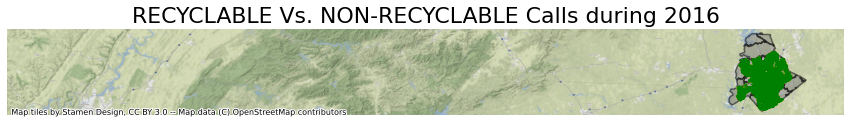

In [22]:
# Layering 2016 repair requests onto the ZipCode Shape File


fig, ax = plt.subplots(figsize=(15,15))

# Plot 1 - Baselayer (zip code shape file)
charlotte_zipcode_map.plot(ax=ax,
                            color='grey', 
                            edgecolor='black',
                            lw=1.5,
                            alpha=0.5,
                            aspect = 1)

# Plot 2 - Map all 2016 Recycle 311-Calls
recy_year_2016.plot(ax=ax, 
                    color='yellow',
                    markersize=2,
                    alpha=0.4,
                    aspect = 1)

# Plot 3 - Map all 2016 Non-Recycle 311-Calls
non_recy_year_2016.plot(ax=ax, 
                        color='green',
                        markersize=2,
                        alpha=0.2,
                        aspect = 1)



# use the bounding box coordinates to set the x and y limits
# ax.set_xlim(minx - 1000, maxx + 1000) 
# ax.set_ylim(miny - 1000, maxy + 1000)


# no axis
ax.axis('off')
ax.set_title('RECYCLABLE Vs. NON-RECYCLABLE Calls during 2016',fontsize=22)

# add a basemap
ctx.add_basemap(ax, crs = charlotte_zipcode_map.crs.to_string())

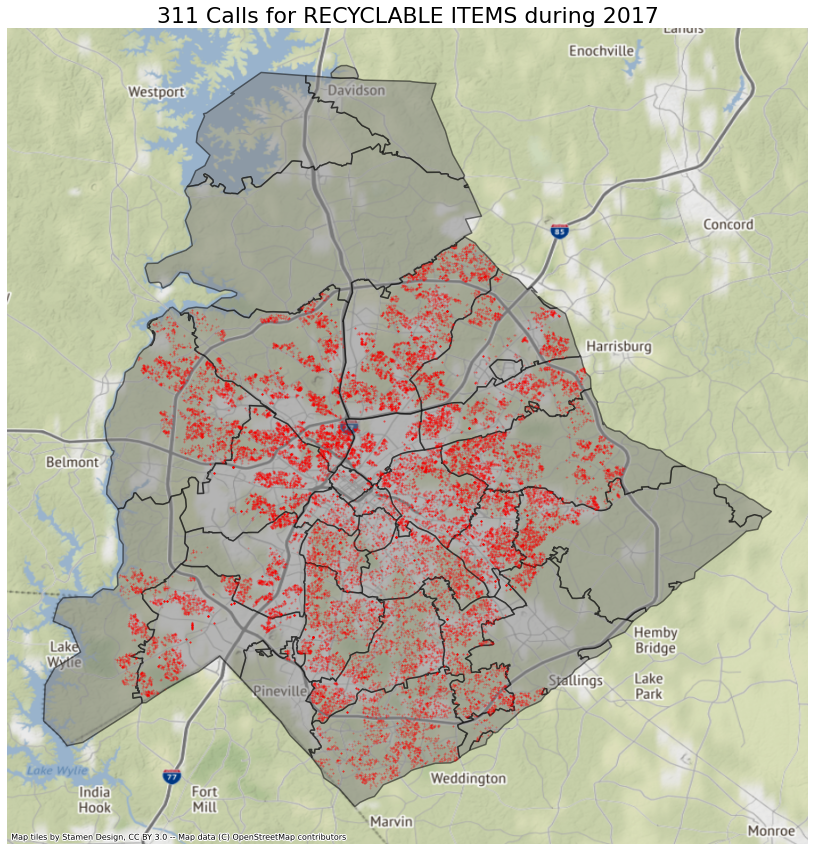

In [23]:
# Layering 2017 repair requests onto the ZipCode Shape File


fig, ax = plt.subplots(figsize=(15,15))

# Plot 1 - Baselayer (zip code shape file)
charlotte_zipcode_map.plot(ax=ax,
                            color='grey', 
                            edgecolor='black',
                            lw=1.5,
                            alpha=0.5)

# Plot 2 - Map all 2017 311-Calls
recy_year_2017.plot(ax=ax, 
                color='red',
                markersize=2,
                alpha=0.2)

# no axis
ax.axis('off')
ax.set_title('311 Calls for RECYCLABLE ITEMS during 2017',fontsize=22)

# add a basemap
ctx.add_basemap(ax, crs = charlotte_zipcode_map.crs.to_string())

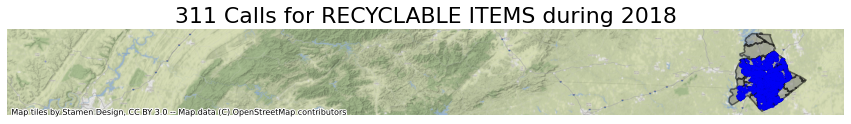

In [24]:
# Layering 2018 Recycle requests onto the ZipCode Shape File


fig, ax = plt.subplots(figsize=(15,15))

# Plot 1 - Baselayer (zip code shape file)
charlotte_zipcode_map.plot(ax=ax,
                            color='grey', 
                            edgecolor='black',
                            lw=1.5,
                            alpha=0.5)


# Plot 4 - Map all Recycle 2018 311-Calls
recy_year_2018.plot(ax=ax, 
                     color='blue',
                     markersize=2,
                     alpha=0.1)



# no axis
ax.axis('off')
ax.set_title('311 Calls for RECYCLABLE ITEMS during 2018',fontsize=22)

# add a basemap
ctx.add_basemap(ax, crs = charlotte_zipcode_map.crs.to_string())

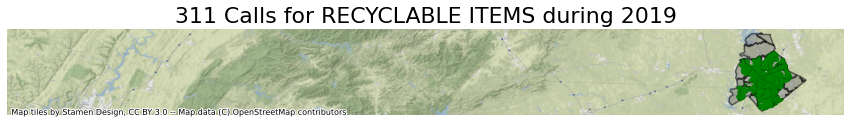

In [25]:
# Layering 2019 Recycle requests onto the ZipCode Shape File


fig, ax = plt.subplots(figsize=(15,15))

# Plot 1 - Baselayer (zip code shape file)
charlotte_zipcode_map.plot(ax=ax,
                            color='grey', 
                            edgecolor='black',
                            lw=1.5,
                            alpha=0.5)


# Plot 2 - Map all Recycle 2018 311-Calls
recy_year_2019.plot(ax=ax, 
                     color='green',
                     markersize=2,
                     alpha=0.1)



# no axis
ax.axis('off')
ax.set_title('311 Calls for RECYCLABLE ITEMS during 2019',fontsize=22)

# add a basemap
ctx.add_basemap(ax, crs = charlotte_zipcode_map.crs.to_string())

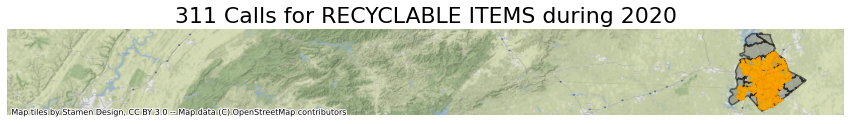

In [26]:
# Layering 2020 Recycle requests onto the ZipCode Shape File


fig, ax = plt.subplots(figsize=(15,15))

# Plot 1 - Baselayer (zip code shape file)
charlotte_zipcode_map.plot(ax=ax,
                            color='grey', 
                            edgecolor='black',
                            lw=1.5,
                            alpha=0.5)

# Plot 2 - Map all Recycle 2021 311-Calls
recy_year_2020.plot(ax=ax, 
                    color='orange',
                    markersize=2,
                    alpha=0.1)

# no axis
ax.axis('off')
ax.set_title('311 Calls for RECYCLABLE ITEMS during 2020',fontsize=22)

# add a basemap
ctx.add_basemap(ax, crs = charlotte_zipcode_map.crs.to_string())

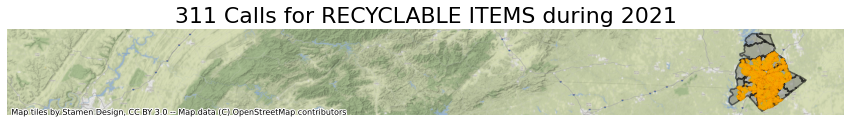

In [27]:
# Layering 2021 Recycle requests onto the ZipCode Shape File


fig, ax = plt.subplots(figsize=(15,15))

# Plot 1 - Baselayer (zip code shape file)
charlotte_zipcode_map.plot(ax=ax,
                                color='grey', 
                                edgecolor='black',
                                lw=1.5,
                                alpha=0.5)

# Plot 2 - Map all Recycle 2021 311-Calls
recy_year_2021.plot(ax=ax, 
                    color='orange',
                    markersize=2,
                    alpha=0.1)

# no axis
ax.axis('off')
ax.set_title('311 Calls for RECYCLABLE ITEMS during 2021',fontsize=22)

# add a basemap
ctx.add_basemap(ax, crs = charlotte_zipcode_map.crs.to_string())

<h2> Data Preprocessing </h2>

<h2> Data Understanding and Exploration </h2>

<h2> Data Preparation for Modeling </h2>

<h2> Modeling </h2>

<h2> Evaluation </h2>

<h2> Results </h2>